In [1]:
from fastai.collab import *
from fastai.tabular import *

## collaborative filtering

This notebook introduces the problem of collaborative filtering. Suppose we have VOD platform with a catalogue of movies and a database of viewers. Suppose further that the viewers rate their movies.

There are 2 ways we can represent this data either as a count_ratings x 3 matrix where each row contains user/movie/rating. This will be a very long matrix. Alternatively, this can be represented as a count_user x count_movies matrix where each entry is the corresponding rating. This matrix while more compact, will tend to be very sparse. Of course, one can build the matrix from the most active users, but we'll get to that.

(I suppose how this matrix can be used for recommendation or is related to embeddings will be discussed soon afterwards)

#### the Cold-Start problem

so a natural issue with recommendation based on this matrix is a new user starts with a blank sheet. So we can't really model said user's taste because well, there's nothing to base it on. There are approaches to tackle this but are beyond this lesson. For Netflix, for example, they can ask a few questions at the beginning for some general taste, they can start suggesting some popular movies and work from there.

I don't know about netflix but spotify seems to do very well here in terms of recommendation, especially of new music.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE); path

WindowsPath('C:/Users/htngu/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv'); ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)
y_range = [0, 5.5] # ??

In [9]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

The model is composed of 2 parts: one for the users, the other for the movies (indices). Each part in turns consists of an embedding matrix with factors and a bias matrix/vector.

In [13]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(101, 50)
  (i_weight): Embedding(101, 50)
  (u_bias): Embedding(101, 1)
  (i_bias): Embedding(101, 1)
)

epoch,train_loss,valid_loss,time
0,1.811932,#na#,00:44


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


(None, None)

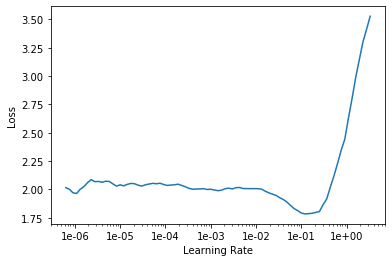

In [10]:
learn.lr_find(), learn.recorder.plot()

In [11]:
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,time
0,1.126430,0.875932,01:29
1,0.774579,0.805289,01:29
2,0.379930,0.759062,01:29


## Movielens 100k dataset 

In [14]:
path=Config.data_path()/'ml-100k'

In [19]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [20]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


("g" for genre --> n-hot encoding here for each movie)

In [21]:
len(ratings)

100000

In [23]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [24]:
data = CollabDataBunch.from_df(rating_movie
                               , seed=42
                               , valid_pct=.1
                               , item_name=title
                              )

Here, Jeremy sets a range for the target value. This in turns means that there will be a scaled sigmoid at the end to "scale" the output values correctly (which he didn't do in the excel sheet and so there were a few negative ratings). We note that the sigmoid function asymptotes the 0 and 1 value without actually getting there, whereas in the ratings, there are ratings going from 0.5 to 5. Thus, to compensate, we set the range to be from 0 to 5.5 so the ratings range is achievable.

In [25]:
y_range =  [0, 5.5]

In [31]:
learn = collab_learner(data, n_factors=40
                       , y_range=y_range
                       , wd=1e-1
                      )

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


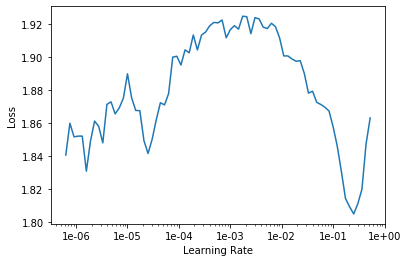

In [27]:
learn.lr_find(); learn.recorder.plot(skip_end=15)

Choosing lr: Jeremy went for 5e-3 in the notebook, saying one could try 10/0.1 * "optimal" lr just to test the water. Much obliged. Considering it doesn't take long.

In [32]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,time
0,0.946736,0.943350,01:40
1,0.846695,0.863739,01:40
2,0.771331,0.834039,01:37
3,0.734989,0.828668,01:38


lr = 1e-2 is not too different, lr=1e-1 fails badly

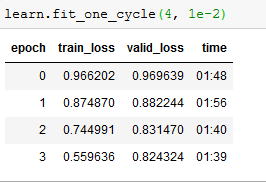

In [33]:
learn.save('collabmodel')

### Interpretation

In [34]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [35]:
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [36]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### movie bias

In [37]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [38]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) 
                 for  i,b in zip(top_movies, movie_bias)]

In [39]:
sorted(movie_ratings, key=lambda o: o[0])[:20]

[(tensor(-0.2964),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2380),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2224), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2076), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.1940), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.1926), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.1849), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.1834), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.1832), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.1809), 'Grease 2 (1982)', 2.0),
 (tensor(-0.1791), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.1776), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.1771), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.1756), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.1751), 'Booty Ca

In [40]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:20]

[(tensor(0.4965), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.4722), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4643), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4501), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.4239), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4076), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4062), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4050), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.3920), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.3861), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.3781), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.3665), 'Apt Pupil (1998)', 4.1),
 (tensor(0.3598), 'Contact (1997)', 3.8035363457760316),
 (tensor(0.3573), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.3524), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.3460), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666

#### movie weights

In [42]:
movie_w = learn.weight(top_movies, is_item=True)
movie_pca = movie_w.pca(3)

In [44]:
factor0, factor1, factor2 = movie_pca.t()

In [47]:
temp_factor = factor0
movie_comp = [(f, i) for f,i in zip(temp_factor, top_movies)]

In [48]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:15]

[(tensor(1.2481), 'Wrong Trousers, The (1993)'),
 (tensor(1.1197), 'Casablanca (1942)'),
 (tensor(1.1190), 'Close Shave, A (1995)'),
 (tensor(1.0795), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(1.0747), 'Chinatown (1974)'),
 (tensor(1.0613), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(1.0424), 'Shall We Dance? (1996)'),
 (tensor(1.0159), 'Godfather, The (1972)'),
 (tensor(1.0045), "One Flew Over the Cuckoo's Nest (1975)"),
 (tensor(1.0010), 'Rear Window (1954)'),
 (tensor(0.9935), 'Secrets & Lies (1996)'),
 (tensor(0.9836), 'Manchurian Candidate, The (1962)'),
 (tensor(0.9754), 'Citizen Kane (1941)'),
 (tensor(0.9727), 'Third Man, The (1949)'),
 (tensor(0.9706), 'Lawrence of Arabia (1962)')]

In [49]:
sorted(movie_comp, key=itemgetter(0), reverse=False)[:15]

[(tensor(-1.3623), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.3426), 'Jungle2Jungle (1997)'),
 (tensor(-1.2568), "McHale's Navy (1997)"),
 (tensor(-1.2367), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.2005), 'Leave It to Beaver (1997)'),
 (tensor(-1.1164), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(-1.1164), 'Grease 2 (1982)'),
 (tensor(-1.0849), 'Home Alone 3 (1997)'),
 (tensor(-1.0490), 'Cutthroat Island (1995)'),
 (tensor(-1.0480), 'Bio-Dome (1996)'),
 (tensor(-1.0344), 'Lawnmower Man 2: Beyond Cyberspace (1996)'),
 (tensor(-1.0245), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0221), 'Congo (1995)'),
 (tensor(-0.9931), 'Batman & Robin (1997)'),
 (tensor(-0.9876), 'Striptease (1996)')]

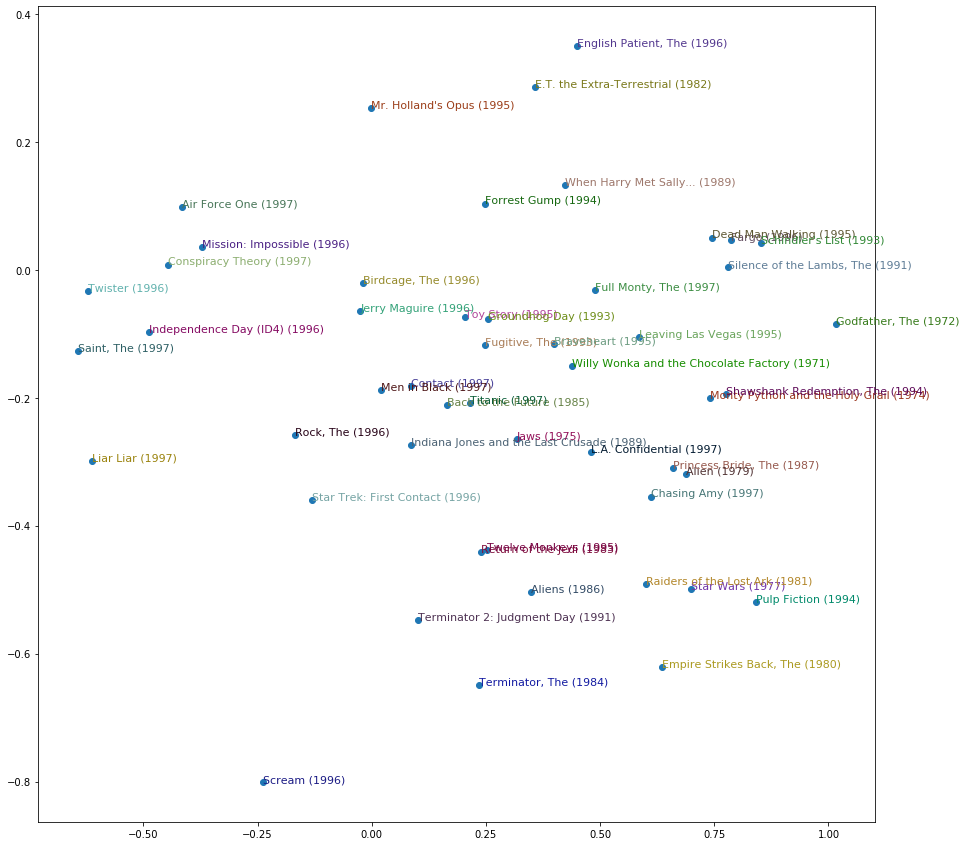

In [50]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = factor0[idxs]
Y = factor2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()